In [1]:
import pandas as pd
import os.path
import matplotlib.pyplot as plt

In [2]:
# Folder where all data for current uber information is kept
raw_data_folder = '/Users/bryan/Movies/Data For TDI Project/Raw_City_Information'
processed_data_folder = '/Users/bryan/Movies/Data For TDI Project/Processed_Data_City_Level'

In [3]:
# List of feature names to drop from this list, as we will not use them for the averaged data I pull out
# Note that although I drop std dev I will be calculating what is arguably a more useful std dev for my analysis
drop_features = ['sourceid','dstid','standard_deviation_travel_time','geometric_mean_travel_time',
                'geometric_standard_deviation_travel_time']

In [4]:
# This holds the definition used to create the smaller, more generalized, dataframes used for comparison

def calc_df(df_weekdays,df_weekends,drop_features):
    
    # Drop selected features from both datasets
    df_weekdays.drop(columns=drop_features,inplace=True)
    df_weekdays.reset_index(inplace=True,drop=True)
    df_weekends.drop(columns=drop_features,inplace=True)
    df_weekends.reset_index(inplace=True,drop=True)

    # Initialize dataframes for holding all information
    main_df = pd.DataFrame()
    temp_travel_df = pd.DataFrame()
    temp_stdDev_df = pd.DataFrame()

    # Add information for hour of day to both dataframes
    main_df['hod'] = df_weekdays['hod'].unique()
    temp_travel_df['hod'] = df_weekdays['hod'].unique()
    temp_stdDev_df['hod'] = df_weekdays['hod'].unique()

    # Store travel information in temp dataframe so it will always be overwritten, avoiding memory problems
    temp_travel_df['mean_travel_time'] = df_weekdays.groupby(df_weekdays['hod']).mean()
    temp_stdDev_df['std_dev_travel_time'] = df_weekdays.groupby(df_weekdays['hod']).std()
    # Delete original dataframe to avoid memory problems
    del df_weekdays
    # Merge this information with the main Dataframe
    main_df = pd.merge(main_df,temp_travel_df[['hod','mean_travel_time']],how='outer',on='hod')
    main_df = pd.merge(main_df,temp_stdDev_df[['hod','std_dev_travel_time']],how='outer',on='hod')
    # After including weekday information rename the columns in the dataframe
    main_df.rename(index=str, columns={"mean_travel_time": "Mean Travel Time (Weekday)", "std_dev_travel_time": "Std Dev Travel Time (Weekdays)"},inplace=True)
    # Now create a new column holding the average weekday travel time (smoothed to represent actual resolution)
    # We thus employ a window of size 3, as all data could have fallen anywhere within a single hour block
    main_df['Mean Travel Time (Weekday) Smoothed'] = main_df['Mean Travel Time (Weekday)'].rolling(3).mean()
    
    # Now include the same information for the weekend
    # Store travel information in temp dataframe so it will always be overwritten, avoiding memory problems
    temp_travel_df['mean_travel_time'] = df_weekends.groupby(df_weekends['hod']).mean()
    temp_stdDev_df['std_dev_travel_time'] = df_weekends.groupby(df_weekends['hod']).std()
    # Delete original dataframe to avoid memory problems
    del df_weekends
    # Merge this information with the main Dataframe
    main_df = pd.merge(main_df,temp_travel_df[['hod','mean_travel_time']],how='outer',on='hod')
    main_df = pd.merge(main_df,temp_stdDev_df[['hod','std_dev_travel_time']],how='outer',on='hod')
    # After including weekday information rename the columns in the dataframe
    main_df.rename(index=str, columns={"hod":"Hour of Day","mean_travel_time": "Mean Travel Time (Weekend)", "std_dev_travel_time": "Std Dev Travel Time (Weekend)"},inplace=True)
    # Now create a new column holding the average weekend travel time (smoothed to represent actual resolution)
    # We thus employ a window of size 3, as all data could have fallen anywhere within a single hour block
    main_df['Mean Travel Time (Weekend) Smoothed'] = main_df['Mean Travel Time (Weekend)'].rolling(3).mean()
    
    return main_df

In [5]:
# Function to plot output of mean travel times for provided city
def plot_mean_times(main_df,city_name):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 17})
    plt.errorbar(main_df['Hour of Day'],main_df['Mean Travel Time (Weekday)'],
                 yerr=main_df['Std Dev Travel Time (Weekdays)'],capthick=2,alpha=0.5,capsize=20,fmt="r--",
                 label='Mean Travel Time (Weekday)')
    plt.errorbar(main_df['Hour of Day'],main_df['Mean Travel Time (Weekend)'],
                 yerr=main_df['Std Dev Travel Time (Weekend)'],capthick=2,alpha=0.5,capsize=20,fmt="b--",
                label='Mean Travel Time (Weekend)')
    
    plt.title("Mean Travel Time on Weekdays Vs Weekends in "+city_name)
    plt.xticks(main_df['Hour of Day'])
    plt.xlabel('Time of Day')
    plt.ylabel('Mean Travel Time (Seconds)')
    plt.legend()
    plt.show()

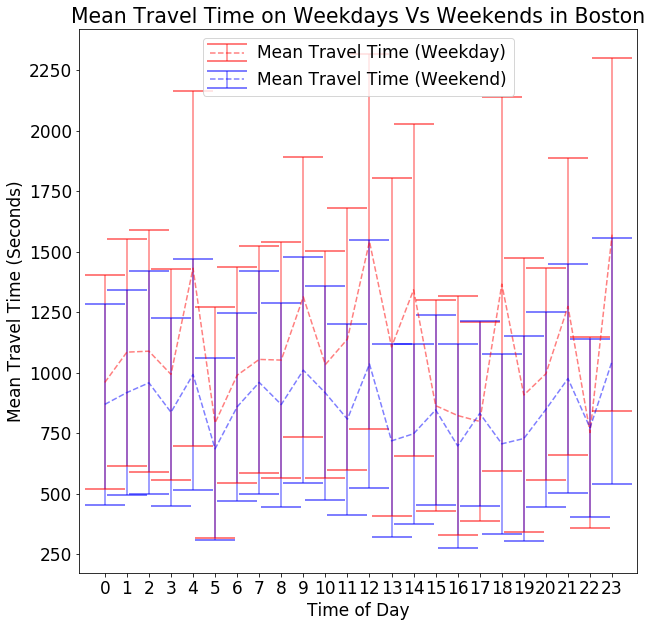

In [6]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of Boston ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'Boston/boston-taz-2018-4-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'Boston/boston-taz-2018-4-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
boston_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
boston_df.sort_values(by=['Hour of Day'],inplace=True)
boston_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(boston_df,'Boston')

boston_df.to_csv(os.path.join(processed_data_folder,'boston_traffic.csv'))

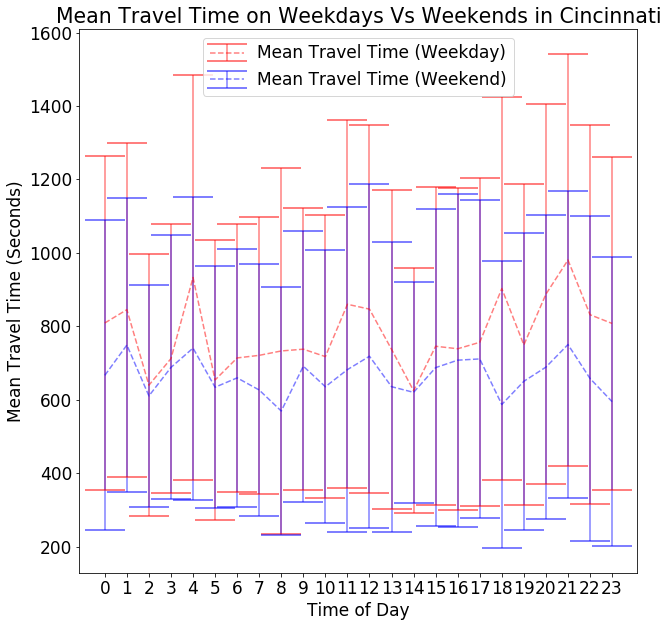

In [7]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of Cincinnati ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'Cincinnati/cincinnati-taz2010-2018-4-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'Cincinnati/cincinnati-taz2010-2018-4-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
cincinnati_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
cincinnati_df.sort_values(by=['Hour of Day'],inplace=True)
cincinnati_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(cincinnati_df,'Cincinnati')

cincinnati_df.to_csv(os.path.join(processed_data_folder,'cincinnati_traffic.csv'))

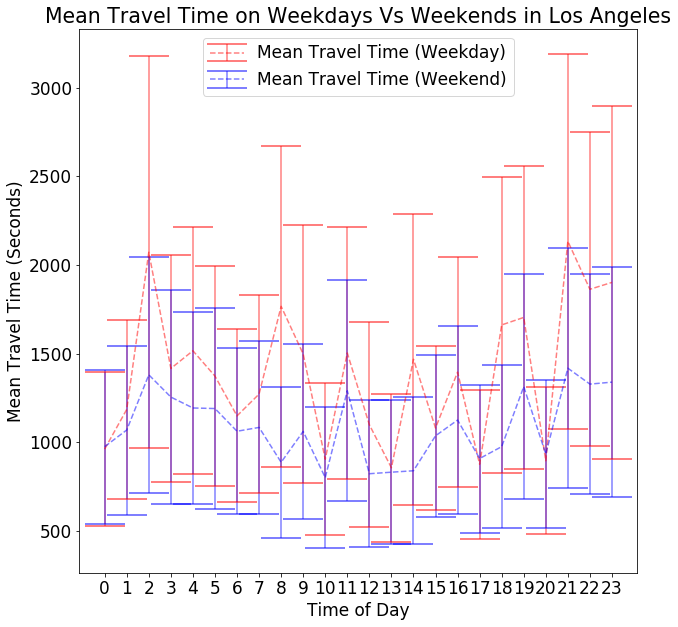

In [8]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of Los Angeles ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'Los Angeles/los_angeles-taz-2018-4-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'Los Angeles/los_angeles-taz-2018-4-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
los_angeles_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
los_angeles_df.sort_values(by=['Hour of Day'],inplace=True)
los_angeles_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(los_angeles_df,'Los Angeles')

los_angeles_df.to_csv(os.path.join(processed_data_folder,'los_angeles_traffic.csv'))

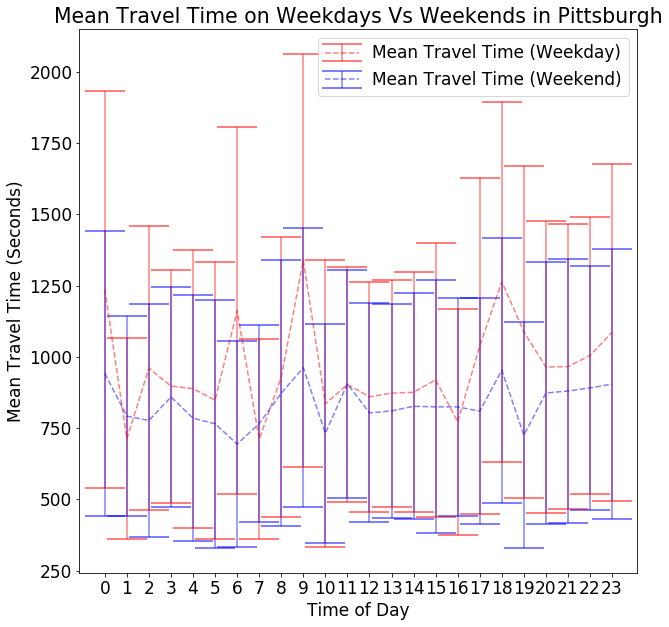

In [9]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of Pittsburgh ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'Pittsburgh/pittsburgh-taz-2018-3-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'Pittsburgh/pittsburgh-taz-2018-3-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
pittsburgh_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
pittsburgh_df.sort_values(by=['Hour of Day'],inplace=True)
pittsburgh_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(pittsburgh_df,'Pittsburgh')

pittsburgh_df.to_csv(os.path.join(processed_data_folder,'pittsburgh_traffic.csv'))

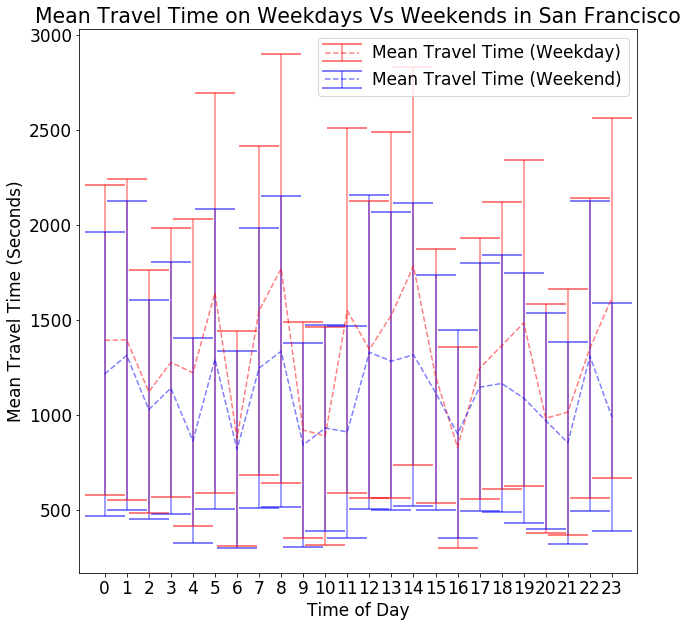

In [10]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of San Francisco ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'San Francisco/san_francisco-taz-2018-3-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'San Francisco/san_francisco-taz-2018-3-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
san_francisco_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
san_francisco_df.sort_values(by=['Hour of Day'],inplace=True)
san_francisco_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(san_francisco_df,'San Francisco')

san_francisco_df.to_csv(os.path.join(processed_data_folder,'san_francisco_traffic.csv'))

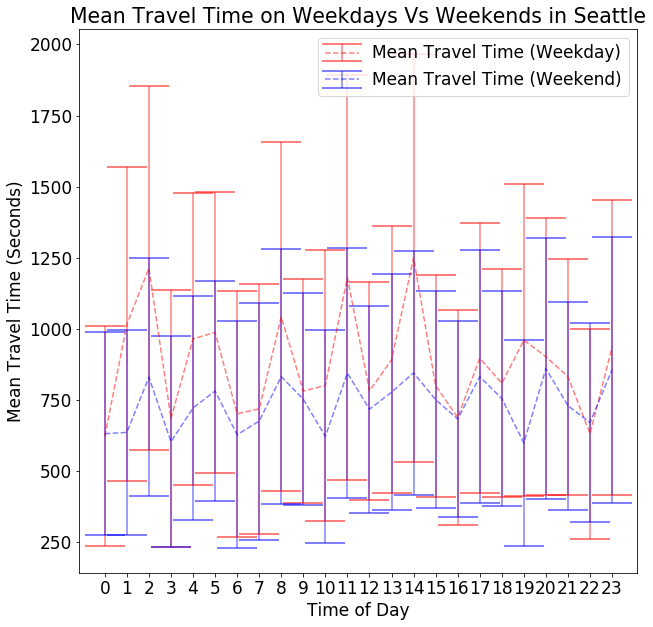

In [11]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of Seattle ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'Seattle/seattle-taz-2018-3-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'Seattle/seattle-taz-2018-3-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
seattle_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
seattle_df.sort_values(by=['Hour of Day'],inplace=True)
seattle_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(seattle_df,'Seattle')

seattle_df.to_csv(os.path.join(processed_data_folder,'seattle_traffic.csv'))

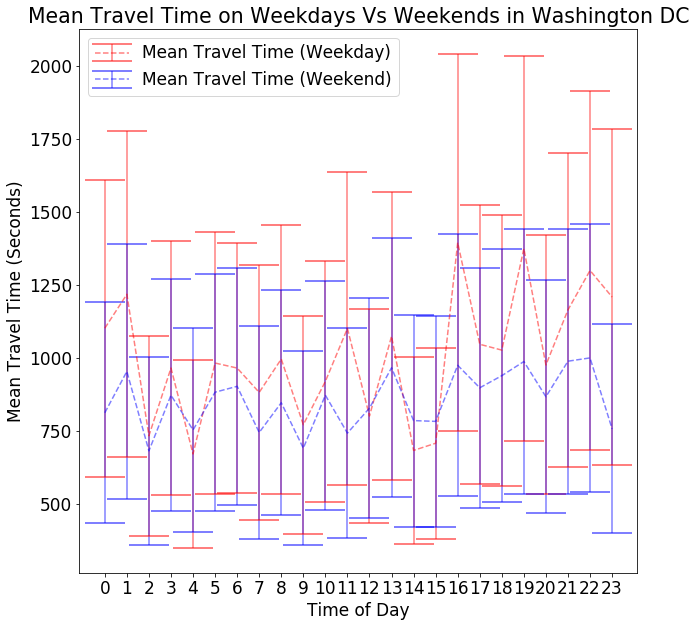

In [12]:
# We now calculate a single average travel time for each hour of the day (separate for weekdays and weekends)
# At the same time we calculate the standard deviation for all average travel times for each hour

###### This box examines the city of Washington DC ##########

# Read in data for Boston (weekday and weekend separately)
df_weekdays = pd.read_csv(os.path.join(raw_data_folder,'Washington DC/washington_DC-taz-2018-3-OnlyWeekdays-HourlyAggregate.csv'))
df_weekends = pd.read_csv(os.path.join(raw_data_folder,'Washington DC/washington_DC-taz-2018-3-OnlyWeekends-HourlyAggregate.csv'))

# Calculate the smaller, more generalized dataframe for this area
washington_DC_df = calc_df(df_weekdays,df_weekends,drop_features)
del df_weekdays
del df_weekends

# Now sort so we are in increasing order of time of day
washington_DC_df.sort_values(by=['Hour of Day'],inplace=True)
washington_DC_df.reset_index(inplace=True,drop=True)

# Plot results for visual inspection
plot_mean_times(washington_DC_df,'Washington DC')

washington_DC_df.to_csv(os.path.join(processed_data_folder,'washington_DC_traffic.csv'))

In [13]:
# From the above we can see that, surprisingly for me, there is not a significant change in mean travel time
# Depending on time of day for any of the above cities

# There is also not a huge difference between weekday travel times and weekend travel times
# I had expected that there would be

# Also, within a single standard deviation all mean travel times are the same across all times of day, and also
# across weekdays and weekends

# This therefore strengthens my use of a single number for representing a particular cities average travel time